# COVID-19 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import requests
import datetime 
from datetime import date
from datetime import datetime as dt
from pprint import pprint
import warnings
warnings.simplefilter('ignore')

## Setting Up the Data

In [2]:
# Regions
# file = os.path.join('resources', 'demographics', 'regions.ipynb')
# %run '{file}'
file = os.path.join('resources', 'demographics', 'regions.csv')
regions_df = pd.read_csv(file)
# regions_df

#### Training Data

In [3]:
# Both clinically diagnosed and lab-confirmed cases
# Source: https://www.kaggle.com/c/covid19-global-forecasting-week-2
train_data = os.path.join('resources','train.csv')
train_df = pd.read_csv(train_data)
train_df = train_df[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities']]
train_df['Province_State'] = train_df['Province_State'].fillna('')
train_df['Country_Region'].replace('US', 'United States', inplace=True)
# train_df.head()

#### Confirmed Cases

In [70]:
# All Countries
# confirmed_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='ConfirmedCases')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_df = confirmed_df.drop(['Lat','Long','Province/State'], axis=1)
confirmed_df.rename(columns={'Country/Region': 'Country_Region'}, inplace = True)
confirmed_df = confirmed_df.groupby('Country_Region').sum()
# confirmed_df.head()

In [5]:
# By Region
confirmed_df2 = pd.merge(regions_df, confirmed_df, on=['Country_Region'], how='right')
confirmed_df2 = confirmed_df2.drop_duplicates().sort_values(by='Country_Region')
confirmed_r_df = confirmed_df2.groupby('Region').sum()
# confirmed_r_df

In [17]:
# Top Ten Countries
n = 10
last_day = confirmed_df.columns[-1]
top_confirmed_df = confirmed_df.nlargest(n, last_day)
top_confirmed_df.index

Index(['US', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran',
       'United Kingdom', 'Switzerland', 'Turkey'],
      dtype='object', name='Country_Region')

#### Fatalities

In [7]:
# All Countries
# fatalities_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='Fatalities')
fatalities_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
fatalities_df = fatalities_df.drop(['Lat','Long','Province/State'], axis=1)
fatalities_df.rename(columns={'Country/Region': 'Country_Region'}, inplace = True)
fatalities_df = fatalities_df.groupby('Country_Region').sum()
# fatalities_df.head()

In [8]:
# By Region
fatalities_df2 = pd.merge(regions_df, fatalities_df, on=['Country_Region'], how='right')
fatalities_df2 = fatalities_df2.drop_duplicates().sort_values(by='Country_Region')
fatalities_r_df = fatalities_df2.groupby('Region').sum()
# fatalities_r_df

In [18]:
# Top Ten Countries
n = 10
last_day = fatalities_df.columns[-1]
top_fatalities_df = fatalities_df.nlargest(n, last_day)
top_fatalities_df.index

Index(['Italy', 'Spain', 'US', 'France', 'China', 'Iran', 'United Kingdom',
       'Netherlands', 'Germany', 'Belgium'],
      dtype='object', name='Country_Region')

#### Recovered

In [10]:
# All Countries
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
recovered_df = recovered_df.drop(['Lat','Long','Province/State'], axis=1)
recovered_df.rename(columns={'Country/Region': 'Country_Region'}, inplace = True)
recovered_df = recovered_df.groupby('Country_Region').sum()
# recovered_df.head()

In [11]:
# Top Ten Countries
top_recovered_df = recovered_df.loc[recovered_df.index.isin(top_confirmed_df.index)]
# top_recovered_df.head()

In [12]:
# By Region
recovered_df2 = pd.merge(regions_df, recovered_df, on=['Country_Region'], how='right')
recovered_df2 = recovered_df2.drop_duplicates().sort_values(by='Country_Region')
recovered_r_df = recovered_df2.groupby('Region').sum()
# recovered_r_df

#### Infected = Confirmed - Recovered

In [13]:
# All Countries
infected_df = confirmed_df-recovered_df
# infected_df

# Top Ten Countries
top_infected_df = infected_df.loc[infected_df.index.isin(top_confirmed_df.index)]
# top_infected_df

# By Region
infected_df2 = pd.merge(regions_df, infected_df, on=['Country_Region'], how='right')
infected_df2 = infected_df2.drop_duplicates().sort_values(by='Country_Region')
infected_r_df = infected_df2.groupby('Region').sum()
# infected_r_df

## Charting Actual Spread

In [24]:
countries_color = {
    'China': 'r',
    'Italy': 'y',
    'US': 'b',
    'Spain': 'g',
    'Germany': 'c',
    'Iran': 'k',
    'France': 'm',
    'Switzerland': 'r',
    'United Kingdom': 'y',
    'Korea, South': 'b',
    'Netherlands': 'g',
    'Belgium': 'k',
    'Turkey': 'm',
}

# countries_color = {
#     'r', 'y', 'b', 'g', 'c', 'k', 'm',
#     'r', 'y', 'b', 'g', 'c', 'k', 'm',
# }

regions_color = {
    'East Asia & Pacific': 'r', 
    'Europe & Central Asia': 'y', 
    'North America': 'b',    
    'South Asia': 'g', 
    'Middle East & North Africa': 'c',
    'Sub-Saharan Africa ': 'k',
    'Latin America & Caribbean ': 'm', 
}

In [25]:
def chart_doubles(df1, df2, color_index, output_file):

    # x-axis
    dates = df1.columns.tolist()
    days = range(len(dates))

    # y-axis: Confirmed Cases
    c_list = df1.index          # list of countries
    y_confirmed = df1.values.tolist()   # total confirmed cases

    # y-axis: Fatalities
    f_list = df2.index          # list of countries
    y_fatalities = df2.values.tolist()   # total fatalities

    # Subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

    # x-axis labels
    xticks = [day*7 for day in days]   # per week
    xlabels = dates[0::7]

    ax1.set(xlabel="Date", ylabel="Confirmed Cases")
    ax1.set_xticks(xticks) 
    ax1.set_xticklabels(xlabels, rotation=45, ha='right')
    ax2.set(xlabel="Date", ylabel="Fatalities")
    ax2.set_xticks(xticks) 
    ax2.set_xticklabels(xlabels, rotation=45, ha='right')

    # Chart titles
    ax1.set_title("COVID-19 Confirmed Cases (Actual)")
    ax2.set_title("COVID-19 Fatalities (Actual)")

    # Confirmed Cases Line Chart
    c_labels = ()
    c_counter = 0

    for i in c_list:
        ax1.plot(days, y_confirmed[c_counter], 
                 label = c_list, 
                 color = color_index[i], linestyle = '-')

        c_labels += (i,)
        c_counter += 1

    # Fatalities Cases Line Chart
    f_labels = ()
    f_counter = 0
    for i in f_list:
        ax2.plot(days, y_fatalities[f_counter], 
                 label = f_list, 
                 color = color_index[i], linestyle = '-')

        f_labels += (i,)
        f_counter += 1

    # Legends and chart style    
    ax1.legend(c_labels, loc='best')
    ax2.legend(f_labels, loc='best')
    ax1.grid(axis='y'), ax2.grid(axis='y')

    # Save Image
    plt.savefig(output_file)
    plt.tight_layout()
    plt.show()

### Actual Spread (by Countries)

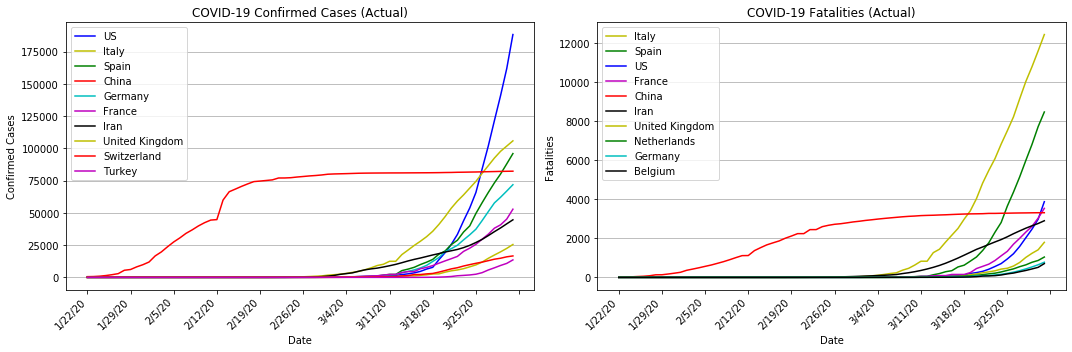

In [27]:
saved_img = os.path.join('images','countries_before.png')
chart_doubles(top_confirmed_df, top_fatalities_df, countries_color, saved_img)

In [28]:
def chart_single(df, output_file):

    # x-axis
    dates = df.columns.tolist()
    days = range(len(dates))

    # y-axis
    regions = df.index                  # list of regions
    top_confirmed = df.values.tolist()  # total confirmed cases

    fig, ax = plt.subplots(figsize = (9,6))
    plt.title("COVID-19 Confirmed Cases (by Region)")
    plt.xlabel("Date")
    plt.ylabel("Confirmed Cases")

    xticks = [day*7 for day in days]
    xlabels = dates[0::7]
    plt.xticks(xticks, xlabels, rotation=45)

    mcolor = ['r','y','b','g','c','k','m']
    counter = 0
    region_labels = ()

    for region in regions:
        ax.plot(days, top_confirmed[counter], label = regions, color = mcolor[counter], linestyle = '-')

        region_labels += (region,)
        counter += 1

        if counter == len(regions):
            break

    plt.legend(region_labels, loc='best')            
    plt.grid(axis='y')
    plt.savefig(output_file)
    plt.tight_layout()
    plt.show()

### Actual Spread (by Regions)

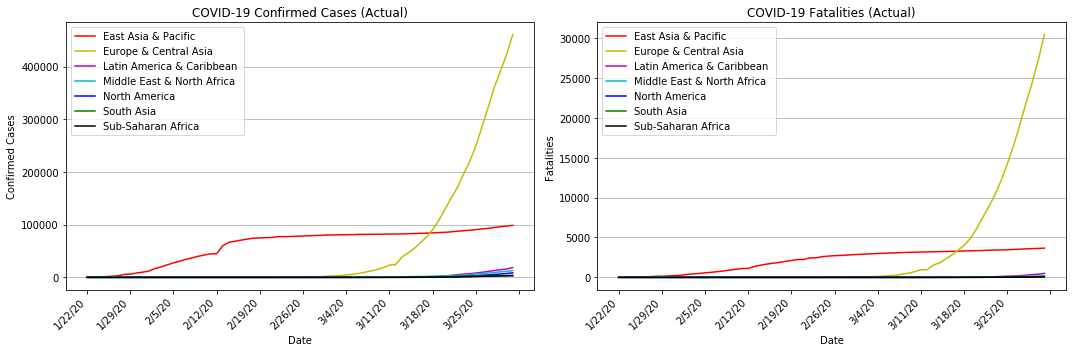

In [29]:
# chart_single(confirmed_r_df, "images/confirmed_regions.png")

saved_img = os.path.join('images','regions_before.png')
chart_doubles(confirmed_r_df, fatalities_r_df, regions_color, saved_img)

## Charting Actual Spread Since First Day

In [30]:
# First Day Values
def first_day(df, country):
    row = list(df.loc[df.index == country].values[0])
    col = next((i for i, j in enumerate(row) if j.any()), None)     
    first_day = df.columns[col]
    return first_day

print(first_day(top_confirmed_df, "Italy"))
print(first_day(top_fatalities_df, "Italy"))

1/31/20
2/21/20


In [31]:
# New dataframes with all non-zero values at beginning
def first_day_df(df):
    dates = df.columns.tolist()
    days = range(len(dates))
    
    new_df = pd.DataFrame(columns=days)

    countries = df.index              # list of countries
    for country in countries:
        # Grab the country's row
        row = list(df.loc[df.index == country].values[0])
        # Grab the column index of first non-zero value
        col = next((i for i, j in enumerate(row) if j.any()), None)     
        # Calculate date
        first_day = df.columns[col]
        # Reset first day
        row = row[col:] + row[:col]
        # New rearranged dataframe
        new_df = new_df.append([row])

    # Same countries indexed
    new_df.index = df.index
    new_df = new_df.replace(0,np.NaN)
    
    return new_df

### Actual Spread (by Countries)

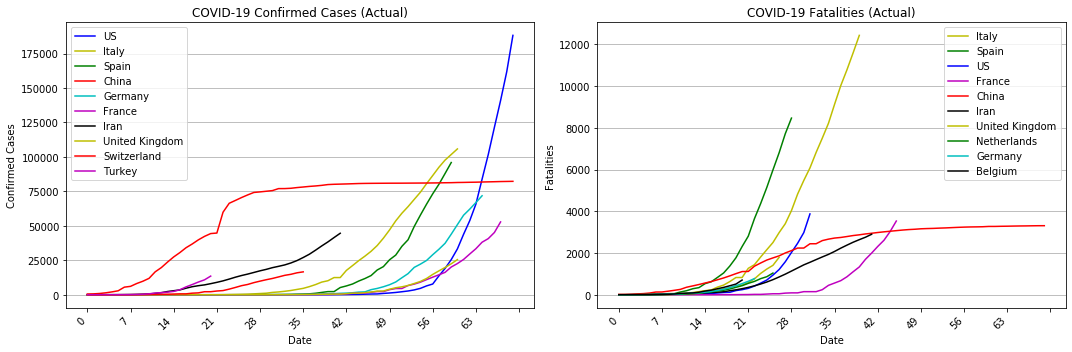

In [32]:
# Confirmed Cases Since First Day
first_confirmed_df = first_day_df(top_confirmed_df)

# Fatalities Since First Day
first_fatalities_df = first_day_df(top_fatalities_df)

# Charts
saved_img = os.path.join('images','countries_byday.png')
chart_doubles(first_confirmed_df, first_fatalities_df, countries_color, saved_img)

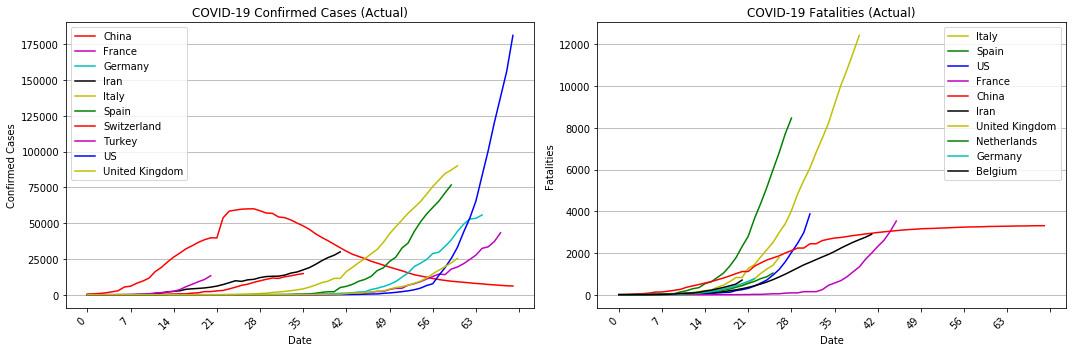

In [33]:
# Infected Since First Day (Less Recovered)
first_infected_df = first_day_df(top_infected_df)

saved_img = os.path.join('images','countries_before_i.png')
chart_doubles(first_infected_df, first_fatalities_df, countries_color, saved_img)

### Actual Spread (by Regions)

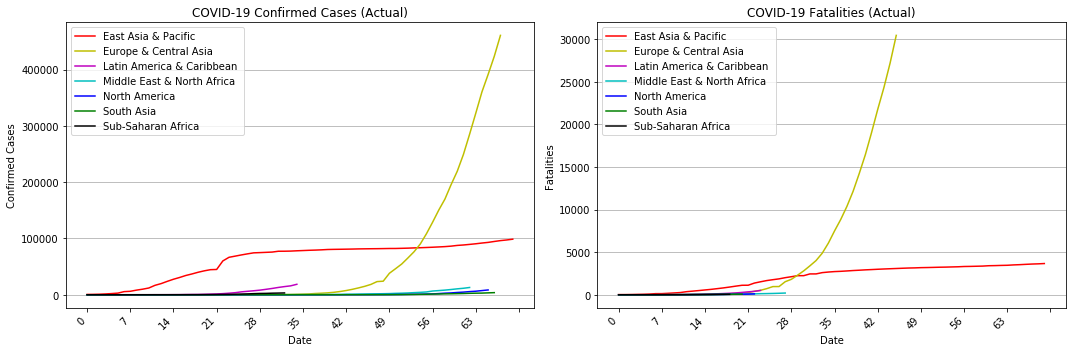

In [34]:
first_confirmed_r_df = first_day_df(confirmed_r_df)
first_fatalities_r_df = first_day_df(fatalities_r_df)

saved_img = os.path.join('images','regions_byday.png')
chart_doubles(first_confirmed_r_df, first_fatalities_r_df, regions_color, saved_img)

## Charting Predicted COVID-19 Spread

In [35]:
# Installations you may need to run this notebook
# !pip install keras
# !pip install tensorflow
# !pip install sklearn --upgrade
# !pip install joblib

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit

### Prediction Period

In [36]:
# Prediction Dates
test_data = os.path.join('resources','test.csv')
test_df = pd.read_csv(test_data)

# Start Date
start = test_df['Date'].min()
start = dt.strptime(start, '%Y-%m-%d')

# End Date
end = test_df['Date'].max()
end = dt.strptime(end, '%Y-%m-%d')

# Date Range
n_days = (end-start).days
n_days

42

### Logarithmic Regression Model 
To account for the exponential rate of infection.

In [37]:
# # Split into Test and Train data
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# # Scale the data
# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

# # Transform the training and test data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

In [38]:
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score

# degree = 2

# # Scale and transform the data
# polyscale = PolynomialFeatures(degree=degree)  
# X_train_poly = polyscale.fit_transform(X_train_scaled)  
# X_test_poly = polyscale.fit_transform(X_test_scaled)  

# # Create the model
# polyline = LinearRegression()  

# # Train the model
# polyline.fit(X_train_poly, y_train_scaled)

# # plt.plot(x_sorted, y_sorted, c="red")

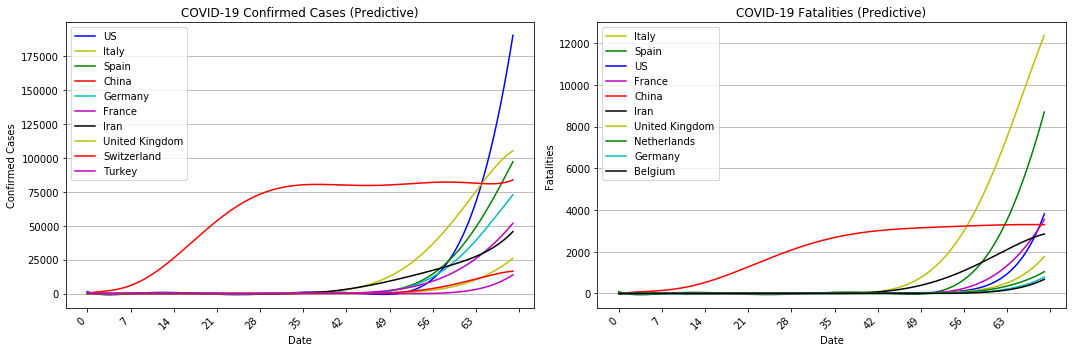

In [39]:
i_days = n_days - 1   # adjust for index
degree = 7            # 2 to adjust for a country's preventive measures such as social distancing and contact tracing

dates = first_confirmed_df.columns.tolist()
days = range(len(dates))

# y-axis: Confirmed Cases
c_countries = first_confirmed_df.index          # list of countries
# y_confirmed = df1.values.tolist()   # total confirmed cases

# y-axis: Fatalities
f_countries = first_fatalities_df.index          # list of countries
# y_fatalities = df2.values.tolist()   # total fatalities

# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

# x-axis labels
xticks = [day*7 for day in days]   # per week
xlabels = dates[0::7]
    
# x-axis labels
ax1.set(xlabel="Date", ylabel="Confirmed Cases")
ax1.set_xticks(xticks) 
ax1.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set(xlabel="Date", ylabel="Fatalities")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xlabels, rotation=45, ha='right')

# Chart titles
ax1.set_title("COVID-19 Confirmed Cases (Predictive)")
ax2.set_title("COVID-19 Fatalities (Predictive)")

# Confirmed Cases Line Chart
c_labels = ()
c_counter = 0

first_confirmed = pd.DataFrame(columns=days)

for country in c_countries:

#     tmp_df = top_confirmed_df.replace(np.NaN,10**-10)  # hack for resolving log(0)
    y = top_confirmed_df.loc[top_confirmed_df.index == country].values[0]
   
    c_polynomial = np.poly1d(np.polyfit(days, y, degree))
    c_polyline = np.linspace(0, days[-1], 1000)
#     c_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax1.plot(c_polyline, c_polynomial(c_polyline), 
             c = countries_color[country], 
             label = c_countries)

#     model_score = r2_score(y, c_polynomial(days))
#     prediction = round(c_polynomial(n_days), -3)  # rounded to 1000's

    c_labels += (country,)
    c_counter += 1
        

# Fatalities Line Chart
f_labels = ()
f_counter = 0

for country in f_countries:
    
#     tmp_df = top_fatalities_df.replace(np.NaN,10**-10)  # hack for resolving log(0)
    y = top_fatalities_df.loc[top_fatalities_df.index == country].values[0]
    
    f_polynomial = np.poly1d(np.polyfit(days, y, degree))
    f_polyline = np.linspace(0, days[-1], 1000)
#     f_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax2.plot(f_polyline, f_polynomial(f_polyline), 
             c = countries_color[country], 
             label = f_countries)

#     model_score = r2_score(y, f_polynomial(days))
#     prediction = round(f_polynomial(n_days), -3)  # rounded to 1000's
    
    f_labels += (country,)
    f_counter += 1    
    
# Legends and chart style    
ax1.legend(c_labels, loc='best')
ax2.legend(f_labels, loc='best')
ax1.grid(axis='y'), ax2.grid(axis='y')

# Save Image
# plt.savefig("images/model_polynomial.png")
plt.tight_layout()
plt.show()

In [40]:
# Mean recovery rate
# recovery_rate = 1/38
first_recovered_df = first_day_df(recovered_df)

top_recovered_df = first_recovered_df.loc[first_recovered_df.index.isin(top_confirmed_df.index)]
top_recovered_df

# test = top_recovered_df[1].values[0] - top_recovered_df[0].values[0]
# test = top_recovered_df.iloc[0,1] - top_recovered_df.iloc[0,0]
# print(test)


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
Country_Region,,,,,,,,,,,,,,,,,,,,,
China,28.0,30.0,36.0,39.0,49.0,58.0,101.0,120.0,135.0,214.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,1.0,1.0,1.0,1.0,1.0,12.0,12.0,12.0,14.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iran,49.0,49.0,73.0,123.0,175.0,291.0,291.0,552.0,739.0,913.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Italy,1.0,2.0,1.0,1.0,3.0,45.0,46.0,46.0,83.0,149.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spain,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Switzerland,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Turkey,26.0,26.0,42.0,70.0,105.0,162.0,243.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### SIR Model
To account for recovered/removed population.

#### Country's Population Data

In [41]:
def get_population(country_code, indicator_code):

    # API Call
    url = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}?format=json"
    response = requests.get(url).json()
    pages = response[0]['pages']
    results = response[1]

    # Loop through results
#     for page in range(pages):
    for i in range(len(results)):

        population = results[i]['value']
        if population is None:
            pass
        else:
            return population
            # Only the most recent value, then break
            break

In [42]:
country_region = 'China'
contact_rate = 0.3
# recovery_rate = 1/38
recovery_rate = 0.0132

country_code = regions_df[regions_df['Country_Region'].str.contains(country_region)]['Country_Code'].values[0]
population = get_population(country_code, 'SP.POP.TOTL')

# By Country
pop_confirmed = int(confirmed_df.loc[confirmed_df.index==country_region].values[0][0])
pop_recovered = int(recovered_df.loc[recovered_df.index==country_region].values[0][0])
pop_fatalities = int(fatalities_df.loc[fatalities_df.index==country_region].values[0][0])
pop_removed = pop_recovered + pop_fatalities
pop_susceptible = population - pop_confirmed - pop_removed


#### SIR Model Chart

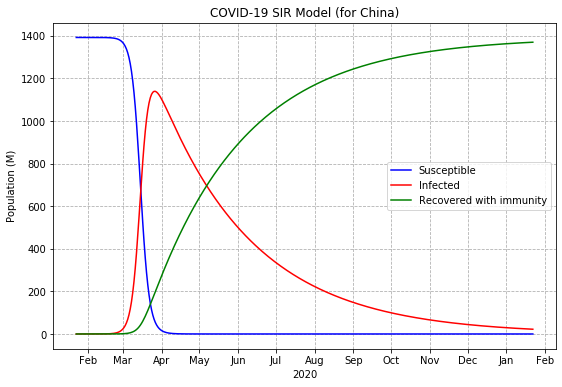

Population, China: 1392.73 M
    Infected: 548   3.93471814350233e-05%,
    Removed: 45   3.2310641689343954e-06%,
    Susceptible: 1392729407   99.99995742175439%

Contact Rate: 0.3, Recovery Rate: 0.0132
As of first day: <function first_day at 0x114dceea0>


In [43]:
from scipy.integrate import odeint
import matplotlib.dates as mdates

# THE DATA
# Total population, N.
N = population
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = pop_confirmed, pop_removed
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = contact_rate, recovery_rate
# A grid of time points (in days)
numdays = 365   # fixed, do not change
t = np.linspace(0, numdays, numdays)

# first day of confirmed case
day1 = first_day(confirmed_df, country_region)
base = dt.strptime(day1, '%m/%d/%y')   
date_list = [base - datetime.timedelta(days=x) for x in range(0, numdays)]
date_list.reverse()

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot()

ax.set_title(f'COVID-19 SIR Model (for {country_region})')
ax.set_xlabel('2020')
ax.set_ylabel('Population (M)')

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
# plt.xlim('Jan','May')

ax.plot(date_list, S/1000000, 'b', label='Susceptible')
ax.plot(date_list, I/1000000, 'r', label='Infected')
ax.plot(date_list, R/1000000, 'g', label='Recovered with immunity')

# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)

plt.legend(loc='best')
plt.grid(axis='both', linestyle='dashed')

plt.savefig("images/model_sir.png")
plt.show()

print(f'''Population, {country_region}: {population/1000000} M
    Infected: {pop_confirmed}   {pop_confirmed/population*100}%,
    Removed: {pop_removed}   {pop_removed/population*100}%,
    Susceptible: {pop_susceptible}   {pop_susceptible/population*100}%
''')
print(f'Contact Rate: {contact_rate}, Recovery Rate: {recovery_rate}')
print(f'As of first day: {first_day}')

## Population Demographics

In [266]:
file = os.path.join('resources','demographics','population.csv')
population_df = pd.read_csv(file)
# population_df.head()

In [267]:
pop_density = population_df.iloc[:,[0,1]]
pop_density_df = pd.merge(regions_df, pop_density, on=['Country_Code'], how='right')
pop_density_df.sort_values('Pop Density (per sqkm)', inplace=True, ascending=False)
pop_density_df.replace('United States', 'US', inplace=True)
# pop_density_df.head()

<Figure size 432x288 with 0 Axes>

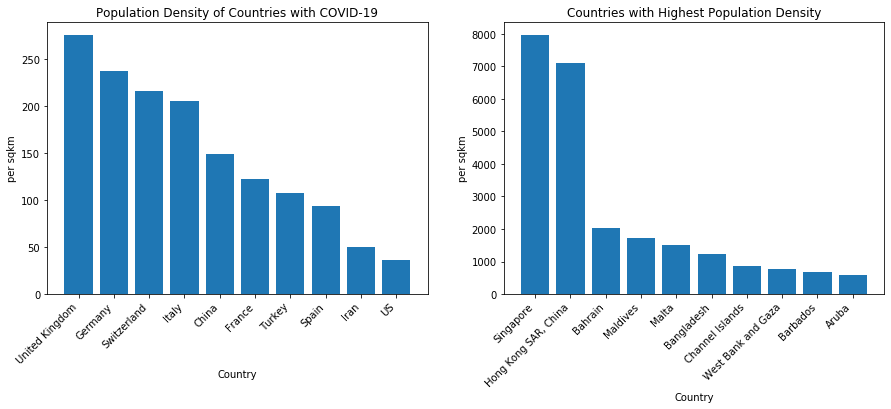

In [268]:
# def chart_doubles_bar(df1, df2):
barchart1 = pop_density_df.loc[pop_density_df['Country_Region'].isin(top_confirmed_df.index)]
barchart2 = pop_density_df.iloc[0:10,:]

fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

x1 = barchart1['Country_Region']
y1 = barchart1['Pop Density (per sqkm)']
ax1.set_title('Population Density of Countries with COVID-19')
ax1.set(xlabel='Country', ylabel='per sqkm')
ax1.set_xticks(range(len(x1)))
ax1.set_xticklabels(x1, rotation=45, ha='right')
ax1.bar(x1, y1, align='center')

x2 = barchart2['Country_Region']
y2 = barchart2['Pop Density (per sqkm)']
ax2.set_title('Countries with Highest Population Density')
ax2.set(xlabel='Country', ylabel='per sqkm')
ax2.set_xticks(range(len(x2)))
ax2.set_xticklabels(x2, rotation=45, ha='right')
ax2.bar(x2, y2, align='center')

plt.show()

In [269]:
pop_prcnt = pd.DataFrame(data=[], columns=population_df.columns)

for row, index in population_df.iterrows():
    pop_total = population_df.iloc[row,11]
    
    pop_prcnt = pop_prcnt.append({
        'Country_Code': population_df.iloc[row,0],
        'Pop Density (per sqkm)':  population_df.iloc[row,1],
        'Ages 0-9': population_df.iloc[row,2]/pop_total,
        'Ages 10-19': population_df.iloc[row,3]/pop_total,
        'Ages 20-29': population_df.iloc[row,4]/pop_total,
        'Ages 30-39': population_df.iloc[row,5]/pop_total,
        'Ages 40-49': population_df.iloc[row,6]/pop_total,
        'Ages 50-59': population_df.iloc[row,7]/pop_total,
        'Ages 60-69': population_df.iloc[row,8]/pop_total,
        'Ages 70-79': population_df.iloc[row,9]/pop_total,
        'Ages 80+': population_df.iloc[row,10]/pop_total,
        'Population Total': pop_total,
    }, ignore_index=True)

# pop_prcnt.head()

## Pre-existing Health Conditions/Burden of Disease

In [270]:
# Source: https://ourworldindata.org/burden-of-disease
# Global Burden of Disease (GBD) 
# 1. Communicable (SH.DTH.COMM.ZS) + Non-communicable (SH.DTH.NCOM.ZS)

# Non-communicable Disease (NCD)
# 2. Respiratory, (Digestive, Diabetes, Cardiovascular)

# Disability-Adjusted Life Year (DALY) 

# NCD Data
ncd_data = os.path.join('resources','health','2017-ncds.csv')
ncd_df = pd.read_csv(ncd_data)
# ncd_df.head()

### Respiratory DALYs of Countries with COVID-19

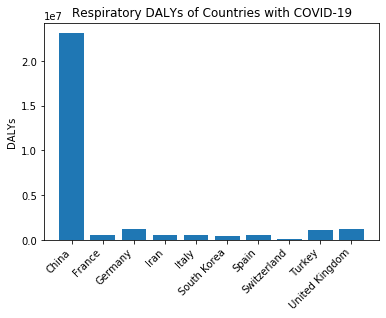

In [271]:
country_list = top_confirmed_df.index
country_list = country_list.insert(0,'South Korea')

# Respiratory Data Only
resp_df = ncd_df.iloc[:,[0,1,4]]
barchart_df = resp_df.loc[resp_df['Country_Region'].isin(country_list)]

x = barchart_df['Country_Region']
y = barchart_df['Respiratory diseases (DALYs lost)']

plt.title('Respiratory DALYs of Countries with COVID-19')
plt.ylabel('DALYs')

plt.bar(x, y, align='center')
plt.xticks(range(len(x)), x, rotation=45, ha='right')

plt.show()

### Respiratory DALYs of Countries (Top 10)

In [272]:
resp_df = pd.merge(regions_df, resp_df, on=['Country_Code','Country_Region'], how='right')
resp_df.dropna(inplace=True)
resp_df = resp_df.sort_values(['Respiratory diseases (DALYs lost)'], ascending=False)
resp_df.head()

,Country_Code,Country_Region,Region,Respiratory diseases (DALYs lost)
73,IND,India,South Asia,3.375676e+07
32,CHN,China,East Asia & Pacific,2.313424e+07
163,USA,United States,North America,5.995479e+06
72,IDN,Indonesia,East Asia & Pacific,3.543650e+06
123,PAK,Pakistan,South Asia,2.485319e+06


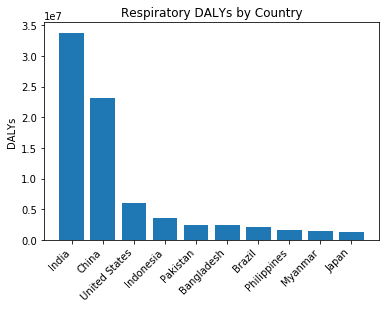

In [273]:
barchart_df = resp_df.iloc[0:10,:]

x = barchart_df['Country_Region']
y = barchart_df['Respiratory diseases (DALYs lost)']

plt.title('Respiratory DALYs by Country')
plt.ylabel('DALYs')

plt.bar(x, y, align='center')
plt.xticks(range(len(x)), x, rotation=45, ha='right')

plt.show()

### Non-Communicable Disease DALYs of Countries (Top 10)

In [274]:
regions_df.replace('Korea, Rep.', 'South Korea', inplace=True)
regions_df.replace('Iran, Islamic Rep.', 'Iran', inplace=True)

dis_data = os.path.join('resources','health','2017-gbds.csv')
dis_df = pd.read_csv(dis_data)
# dis_df.head()

In [275]:
# Old Country Names
diff1 = list(set(dis_df['Country_Region'].values) - set(regions_df['Country_Region'].values))
diff1.sort()
# diff1

In [276]:
# New Country Names
diff2 = list(set(regions_df['Country_Region'].values) - set(dis_df['Country_Region'].values))
diff2.sort()
# diff2

In [277]:
dis_df.replace('Bahamas', 'Bahamas, The', inplace=True)
dis_df.replace('Brunei', 'Brunei Darussalam', inplace=True)
dis_df.replace('Cape Verde', 'Cabo Verde', inplace=True)
dis_df.replace('Democratic Republic of Congo', 'Congo, Dem. Rep.', inplace=True)
dis_df.replace('Congo', 'Congo, Rep.', inplace=True)
dis_df.replace('Egypt', 'Egypt, Arab Rep.', inplace=True)
dis_df.replace('North Korea', 'Korea, Dem. People’s Rep.', inplace=True)
dis_df.replace('Kyrgyzstan', 'Kyrgyz Republic', inplace=True)
dis_df.replace('Laos', 'Lao PDR', inplace=True)
dis_df.replace('Micronesia (country)', 'Micronesia, Fed. Sts.', inplace=True)
dis_df.replace('Macedonia', 'North Macedonia', inplace=True)
dis_df.replace('Russia', 'Russian Federation', inplace=True)
dis_df.replace('Slovakia', 'Slovak Republic', inplace=True)
dis_df.replace('Saint Lucia', 'St. Lucia', inplace=True)
dis_df.replace('Saint Vincent and the Grenadines', 'St. Vincent and the Grenadines', inplace=True)
dis_df.replace('Syria', 'Syrian Arab Republic', inplace=True)
dis_df.replace('Taiwan', 'Taiwan, China', inplace=True)
dis_df.replace('United States Virgin Islands', 'Virgin Islands (U.S.)', inplace=True)
dis_df.replace('Venezuela', 'Venezuela, RB', inplace=True)
dis_df.replace('Yemen', 'Yemen, Rep.', inplace=True)

In [278]:
ncd_df2 = dis_df.iloc[:,[0,1,2]]
ncd_df2 = pd.merge(regions_df, ncd_df2, on=['Country_Code','Country_Region'], how='right')
ncd_df2.dropna(inplace=True)
ncd_df2 = ncd_df2.sort_values(['Non-communicable diseases (NCDs) (DALYs lost)'], ascending=False)
ncd_df2.head()

,Country_Code,Country_Region,Region,Non-communicable diseases (NCDs) (DALYs lost)
34,CHN,China,East Asia & Pacific,3.070024e+08
80,IND,India,South Asia,2.691763e+08
179,USA,United States,North America,8.522137e+07
79,IDN,Indonesia,East Asia & Pacific,5.221560e+07
146,RUS,Russian Federation,Europe & Central Asia,4.762609e+07


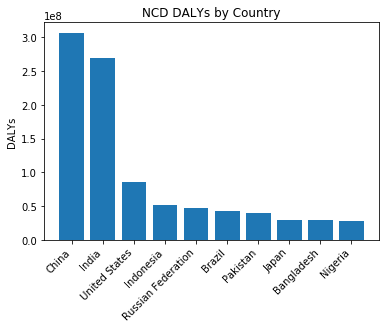

In [279]:
country_list = top_confirmed_df.index
country_list = country_list.insert(0,'South Korea')

barchart_df = ncd_df2.iloc[0:10,:]

x = barchart_df['Country_Region']
y = barchart_df['Non-communicable diseases (NCDs) (DALYs lost)']

plt.title('NCD DALYs by Country')
plt.ylabel('DALYs')

plt.bar(x, y, align='center')
plt.xticks(range(len(x)), x, rotation=45, ha='right')

plt.show()

### NCD DALYs of Countries with COVID-19

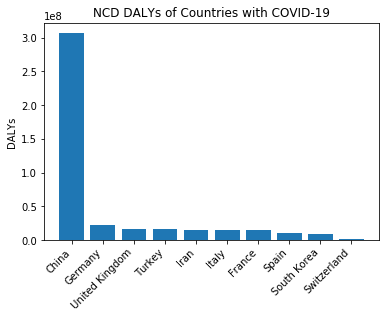

In [280]:
# Respiratory Data Only
barchart_df = ncd_df2.loc[ncd_df2['Country_Region'].isin(country_list)]

x = barchart_df['Country_Region']
y = barchart_df['Non-communicable diseases (NCDs) (DALYs lost)']

plt.title('NCD DALYs of Countries with COVID-19')
plt.ylabel('DALYs')

plt.bar(x, y, align='center')
plt.xticks(range(len(x)), x, rotation=45, ha='right')

plt.show()

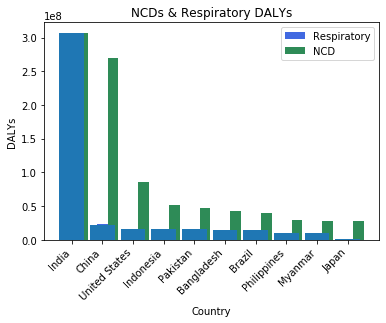

In [281]:
# country_list = top_confirmed_df.index
ind = np.arange(10)  # the x locations for the groups

resp_y = resp_df.iloc[0:10,:]
ncd_y = ncd_df2.iloc[0:10,:]

x = resp_y['Country_Region']
y1 = resp_y['Respiratory diseases (DALYs lost)']
y2 = ncd_y['Non-communicable diseases (NCDs) (DALYs lost)']

fig = plt.figure()
ax = fig.add_subplot()
width = 0.35       # the width of the bars

rects1 = ax.bar(ind, y1, width, color='royalblue')
rects2 = ax.bar(ind+width, y2, width, color='seagreen')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x)

ax.legend( (rects1[0], rects2[0]), ('Respiratory', 'NCD') )

plt.title('NCDs & Respiratory DALYs')
plt.ylabel('DALYs')
plt.xlabel('Country')

plt.bar(x, y, align='center')
plt.xticks(range(len(x)), x, rotation=45, ha='right')

plt.show()

In [290]:
ml_df = pd.merge(ncd_df2, resp_df, on=['Country_Code', 'Country_Region', 'Region'], how='inner')
print(len(ml_df))
ml_df2 = pd.merge(ml_df, pop_prcnt, on=['Country_Code'], how='inner')
print(len(ml_df2))
ml_df2

171
154


,Country_Code,Country_Region,Region,Non-communicable diseases (NCDs) (DALYs lost),Respiratory diseases (DALYs lost),Pop Density (per sqkm),Ages 0-9,Ages 10-19,Ages 20-29,Ages 30-39,Ages 40-49,Ages 50-59,Ages 60-69,Ages 70-79,Ages 80+,Population Total
0,CHN,China,East Asia & Pacific,3.070024e+08,2.313424e+07,148.348833,0.120531,0.116876,0.141732,0.151214,0.161577,0.144194,0.101578,0.044524,0.017774,1.392730e+09
1,IND,India,South Asia,2.691763e+08,3.375676e+07,454.938073,0.176418,0.186754,0.175290,0.154398,0.120042,0.090770,0.060147,0.026784,0.009397,1.352617e+09
2,USA,United States,North America,8.522137e+07,5.995479e+06,35.766089,0.122578,0.129520,0.141230,0.132424,0.123287,0.131400,0.113570,0.067159,0.038832,3.271674e+08
3,IDN,Indonesia,East Asia & Pacific,5.221560e+07,3.543650e+06,147.752190,0.179325,0.173233,0.158785,0.154975,0.137230,0.102690,0.058935,0.026280,0.008546,2.676634e+08
4,BRA,Brazil,Latin America & Caribbean,4.303306e+07,2.146048e+06,25.061716,0.139769,0.153450,0.163322,0.163782,0.135562,0.112551,0.074991,0.038442,0.018131,2.094693e+08
5,PAK,Pakistan,South Asia,4.009144e+07,2.485319e+06,275.289319,0.244993,0.209462,0.182709,0.136047,0.094085,0.067186,0.038375,0.020593,0.006550,2.122150e+08
6,JPN,Japan,East Asia & Pacific,2.920931e+07,1.354109e+06,347.073458,0.082910,0.089742,0.097433,0.118294,0.148805,0.125550,0.132496,0.120646,0.084122,1.265291e+08
7,BGD,Bangladesh,South Asia,2.870732e+07,2.448171e+06,1239.579312,0.181627,0.192595,0.182229,0.159956,0.121867,0.086161,0.040787,0.024823,0.009955,1.613560e+08
8,NGA,Nigeria,Sub-Saharan Africa,2.814857e+07,1.207570e+06,215.064989,0.314003,0.229422,0.160241,0.118982,0.081048,0.051368,0.030028,0.012701,0.002207,1.958747e+08
9,MEX,Mexico,Latin America & Caribbean,2.275945e+07,1.026299e+06,64.914626,0.176836,0.177138,0.170180,0.145930,0.127677,0.095432,0.060472,0.030762,0.015573,1.261908e+08


In [283]:
# Countries with no disease information
# Russia, Iran, etc.
difference1 = list(set(confirmed_df.index.values) - set(ml_df2['Country_Region'].values))
difference1.sort()
difference1
len(difference1)

# Double check
# for i in range(len(difference1)):
#     yes = ml_df2['Country_Region'].str.contains(difference1[i])
#     if yes.any():
#         print(difference1[i])

42

In [295]:
# Old Country Names
difference2 = list(set(confirmed_df.index.values) - set(regions_df['Country_Region'].values))
difference2.sort()
# difference2

In [285]:
# New Country Names
difference3 = list(set(regions_df['Country_Region'].values) - set(confirmed_df.index.values))
difference3.sort()
# difference3

In [292]:
# Replace Country Names
first_day_confirmed = confirmed_df.iloc[:,[0,-1]]
first_day_confirmed.replace('Bahamas', 'Bahamas, The', inplace=True)
first_day_confirmed.replace('Brunei', 'Brunei Darussalam', inplace=True)
first_day_confirmed.replace('Burma', 'Myanmar', inplace=True)
first_day_confirmed.replace('Congo (Brazzaville)', 'Congo, Rep.', inplace=True)
first_day_confirmed.replace('Congo (Kinshasa)', 'Congo, Dem. Rep.', inplace=True)
first_day_confirmed.replace('Czechia', 'Czech Republic', inplace=True)
# first_day_confirmed.replace('Diamond Princess', '', inplace=True)   # Cruise ship
first_day_confirmed.replace('Egypt', 'Egypt, Arab Rep.', inplace=True)
first_day_confirmed.replace('Gambia', 'Gambia, The', inplace=True)
# first_day_confirmed.replace('Holy See', '', inplace=True)   # Church
first_day_confirmed.replace('Korea, South', 'South Korea', inplace=True)
first_day_confirmed.replace('Kyrgyzstan', 'Kyrgyz Republic', inplace=True)
first_day_confirmed.replace('Laos', 'Lao PDR', inplace=True)
# first_day_confirmed.replace('MS Zaandam', '', inplace=True)   # Cruise ship
first_day_confirmed.replace('Russia', 'Russian Federation', inplace=True)
first_day_confirmed.replace('Saint Kitts and Nevis', 'St. Kitts and Nevis', inplace=True)
first_day_confirmed.replace('Saint Lucia', 'St. Lucia', inplace=True)
first_day_confirmed.replace('Saint Vincent and the Grenadines', 'St. Vincent and the Grenadines', inplace=True)
first_day_confirmed.replace('Slovakia', 'Slovak Republic', inplace=True)
first_day_confirmed.replace('Syria', 'Syrian Arab Republic', inplace=True)
first_day_confirmed.replace('Taiwan*', 'Taiwan, China', inplace=True)
first_day_confirmed.replace('US', 'United States', inplace=True)
first_day_confirmed.replace('Venezuela', 'Venezuela, RB', inplace=True)

first_day_confirmed.reset_index(inplace=True)
# first_day_confirmed

In [293]:
ml_df3 = pd.merge(first_day_confirmed, ml_df2, on=['Country_Region'], how='inner')
print(len(ml_df3))
ml_df3

138


,Country_Region,1/22/20,3/31/20,Country_Code,Region,Non-communicable diseases (NCDs) (DALYs lost),Respiratory diseases (DALYs lost),Pop Density (per sqkm),Ages 0-9,Ages 10-19,Ages 20-29,Ages 30-39,Ages 40-49,Ages 50-59,Ages 60-69,Ages 70-79,Ages 80+,Population Total
0,Afghanistan,0,174,AFG,South Asia,6.948558e+06,3.591217e+05,56.937760,0.295644,0.254022,0.175506,0.114011,0.073628,0.046054,0.026612,0.011763,0.002760,37172388.0
1,Albania,0,243,ALB,Europe & Central Asia,6.276270e+05,2.515125e+04,104.612263,0.115932,0.135609,0.169658,0.126100,0.117269,0.137702,0.105786,0.064589,0.027355,2866376.0
2,Algeria,0,716,DZA,Middle East & North Africa,7.036442e+06,3.303591e+05,17.730075,0.220813,0.147823,0.164383,0.167842,0.119867,0.084425,0.055158,0.026990,0.012701,42228429.0
3,Angola,0,7,AGO,Sub-Saharan Africa,4.181835e+06,2.277634e+05,24.713052,0.337316,0.236616,0.161649,0.111513,0.072069,0.044858,0.023043,0.010207,0.002731,30809764.0
4,Antigua and Barbuda,0,7,ATG,Latin America & Caribbean,1.778531e+04,5.944141e+02,218.831818,0.149727,0.146995,0.153455,0.146061,0.144710,0.127324,0.076099,0.038585,0.017044,96282.0
5,Argentina,0,1054,ARG,Latin America & Caribbean,8.999388e+06,4.904146e+05,16.258510,0.167069,0.159701,0.157238,0.143374,0.122783,0.097230,0.077346,0.048940,0.026319,44494503.0
6,Armenia,0,532,ARM,Europe & Central Asia,7.690131e+05,3.370565e+04,103.680225,0.143008,0.120451,0.153453,0.163466,0.114294,0.131917,0.099987,0.041790,0.031632,2951772.0
7,Australia,0,4559,AUS,East Asia & Pacific,4.880078e+06,3.154757e+05,3.249129,0.130135,0.121637,0.137665,0.144292,0.131244,0.123821,0.102940,0.067805,0.040462,24992370.0
8,Austria,0,10180,AUT,Europe & Central Asia,2.089179e+06,1.015699e+05,107.206927,0.095501,0.098527,0.127050,0.135292,0.137351,0.156132,0.109173,0.088385,0.052588,8847039.0
9,Azerbaijan,0,298,AZE,Europe & Central Asia,2.366333e+06,8.820752e+04,120.265320,0.167675,0.131739,0.172977,0.167961,0.126063,0.128100,0.068615,0.023265,0.013606,9942331.0


In [350]:
selected_features = ml_df3.columns[5:-1]
X = ml_df3[selected_features]
X.shape

(138, 12)

In [351]:
y = ml_df3.iloc[:,2]
shapeY = np.reshape(tuple(y), (-1, 1))
shapeY.shape
y.shape

(138,)

In [352]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(testX, testY, random_state=42)

In [353]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[1.72000e+02 6.64000e+02 1.74000e+02 8.70000e+01 1.00000e+00 1.10900e+03
 2.00000e+00 1.50000e+01 1.65100e+03 5.00000e+00 1.50000e+01 3.00000e+00
 1.43000e+02 3.00000e+01 3.99000e+02 9.00000e+00 4.40000e+01 1.92000e+02
 5.00000e+00 2.73800e+03 5.70000e+01 3.38000e+02 2.98000e+02 3.47000e+02
 1.56300e+03 1.09000e+02 1.69000e+02 4.92000e+02 3.00000e+00 4.46050e+04
 5.35800e+03 1.61000e+02 1.05400e+03 1.00000e+01 2.80000e+01 5.28270e+04
 8.67000e+02 1.79000e+02 2.70000e+01 4.55900e+03 1.20000e+01 1.05792e+05
 1.80000e+01 8.02000e+02 6.45000e+02 1.01800e+04 1.52000e+02 1.18100e+03
 7.00000e+00 4.00000e+00 3.03900e+03 1.95300e+03 9.00000e+02 5.32000e+02
 6.47000e+02 1.90000e+01 9.26000e+02 1.31400e+03 1.60000e+01 1.35000e+02
 2.60000e+01 4.64100e+03 1.41000e+02 2.12000e+02 5.37000e+02 1.00000e+01
 5.00000e+00 2.24000e+03 8.00000e+00 8.00000e+00 1.41800e+03 1.09000e+02
 9.59230e+04 1.66050e+04 2.20000e+01 2.89000e+02 9.06000e+02 2.54810e+04
 1.20000e+01 1.13500e+03 7.00000e+00 2.62000e+02 7.00000e+00 7.81000e+02
 1.35310e+04 2.43000e+02 7.18080e+04 5.71700e+03 7.16000e+02 2.61000e+02
 1.06500e+03 1.93800e+03 5.00000e+00 1.20000e+01 5.90000e+01 9.00000e+00
 8.00000e+00 4.00000e+00 3.60000e+01 7.44300e+03 1.27750e+04 1.26670e+04
 6.50000e+01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [349]:
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)
# predictions = classifier.predict(X_test)

# MSE = mean_squared_error(y_test, predictions)
# # r2 = classifier.score(X_test_scaled, y_test_scaled)
# # print(f"MSE: {MSE}, R2: {r2}")
# print(f"MSE: {MSE}")

# print(f"Training Data Score: {classifier.score(X_train, y_train)}")
# print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').